# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\s

In [84]:
btc = pd.read_csv('../data/model2.csv')
btc.set_index('Date', inplace=True)

# Modelling

## Model 1: ARIMA

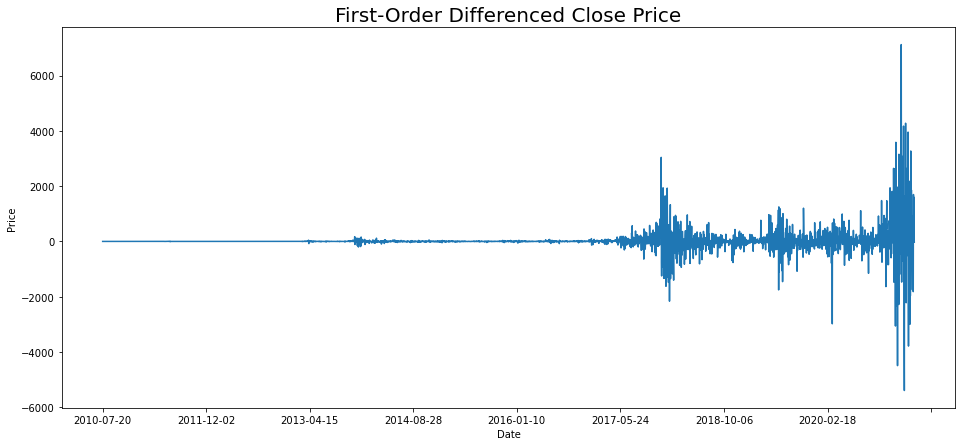

In [ ]:
df_arima = btc[['Close', 'Close_Diff1', 'Year']]

df_arima['Close_Diff1'].plot(figsize=(16,7))
plt.ylabel('Price')
plt.title("First-Order Differenced Close Price", size=20);

We want a shorter timeframe for ARIMA forecasting as we see quite a big variation in the dataset in times of the differenced `Close`. We'll select data from 2020 onwards.

In [ ]:
df_arima = df_arima[df_arima['Year'] > 2019]

### Autocorrelation

Let's take a look at the auto-correlation (ACF) plots on `Close` and `Close_Diff`.

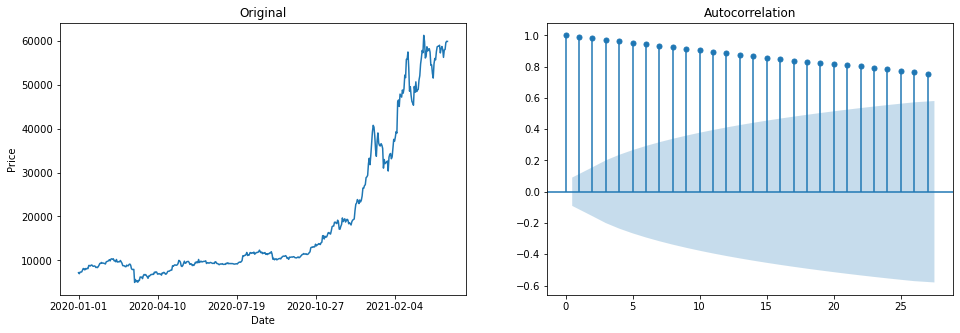

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].plot(ax=ax1)
ax1.set_title('Original')
ax1.set_ylabel('Price')
plot_acf(df_arima['Close'], ax=ax2);

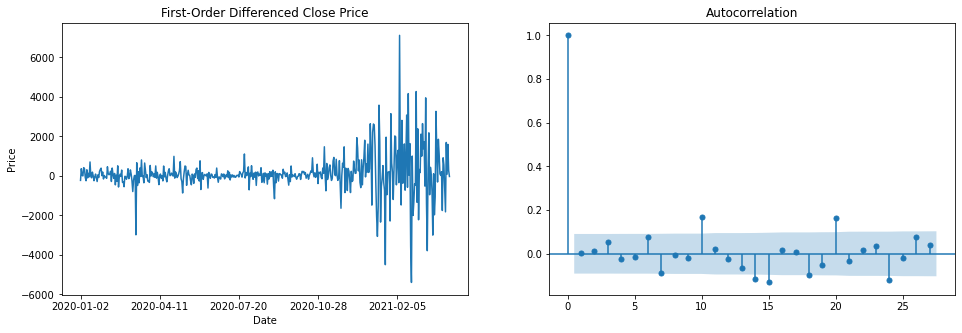

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].diff().dropna().plot(ax=ax1)
ax1.set_title('First-Order Differenced Close Price')
ax1.set_ylabel('Price')
plot_acf(df_arima['Close'].diff().dropna(), ax=ax2);

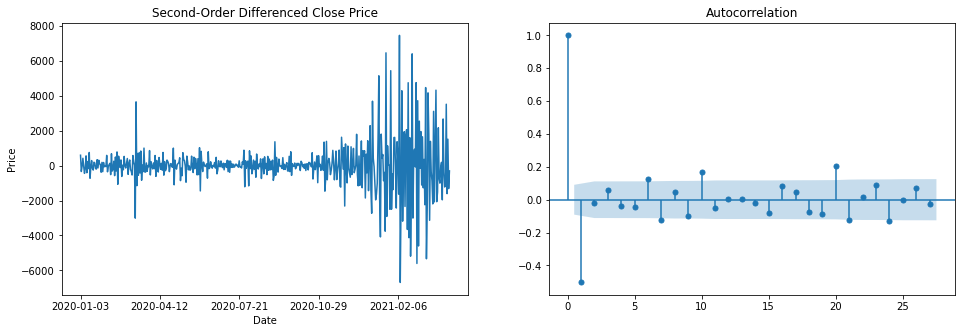

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].diff().diff().dropna().plot(ax=ax1)
ax1.set_title('Second-Order Differenced Close Price')
ax1.set_ylabel('Price')
plot_acf(df_arima['Close'].diff().diff().dropna(), ax=ax2);

We can see that taking the differenced `Close` cause our data to be independent. The first ACF plot shows clear correlations on each lagged values on each other. The second ACF plot shows that we managed to eliminate the correlation. The third ACF has a negative correlated for the first lagged value, possibly due to over differencing. We can conclude that the first difference is sufficient for our ARIMA model.

We also take a look at the partial autocorrelation (PACF) plot below.

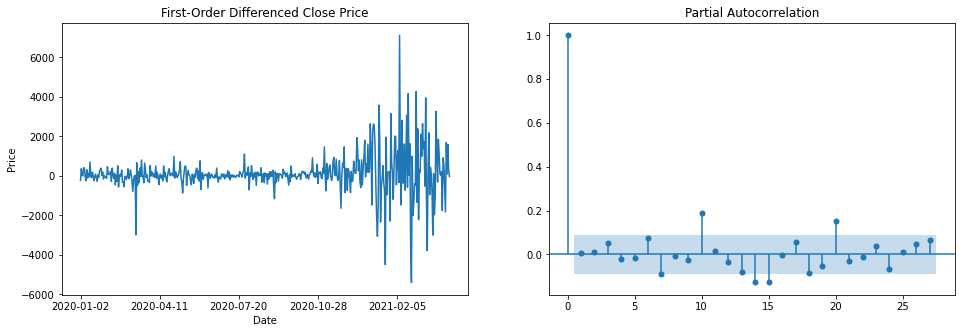

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
df_arima['Close'].diff().dropna().plot(ax=ax1)
ax1.set_title('First-Order Differenced Close Price')
ax1.set_ylabel('Price')
plot_pacf(df_arima['Close'].diff().dropna(), ax=ax2);

We observe that the PACF at lag 10 and 20 are significant as they are above the significance line.

### Fit

Split data to train (90%) and test (10%)

In [ ]:
y_train, y_test = train_test_split(
    df_arima['Close'],
    test_size = 0.1,
    shuffle = False
)

Gridsearch to find optimal parameters

In [ ]:
warnings.filterwarnings('ignore')

best_aic = 9999999999999999999999
best_p = 0
best_q = 0

for p in range(10):
    for q in range(6):
        try:
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q)) # values of p, d, q
            model = arima.fit()
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass

print(f'Best parameters to minimize AIC are:({best_p},1,{best_q}).')
print(f'AIC: {best_aic}')

warnings.filterwarnings('default')

The AIC for ARIMA(0,1,0) is: 6885.354197002516
The AIC for ARIMA(0,1,1) is: 6886.725182119597
The AIC for ARIMA(0,1,2) is: 6888.040927786038
The AIC for ARIMA(0,1,3) is: 6889.377882227386
The AIC for ARIMA(0,1,4) is: 6890.189490016011
The AIC for ARIMA(0,1,5) is: 6890.0826909471925
The AIC for ARIMA(1,1,0) is: 6886.768871070997
The AIC for ARIMA(1,1,1) is: 6887.551603290984
The AIC for ARIMA(1,1,2) is: 6889.27235648758
The AIC for ARIMA(1,1,3) is: 6890.98301888057
The AIC for ARIMA(1,1,4) is: 6891.912986295879
The AIC for ARIMA(1,1,5) is: 6880.786232607413
The AIC for ARIMA(2,1,0) is: 6888.240441539361
The AIC for ARIMA(2,1,1) is: 6889.2293088769975
The AIC for ARIMA(2,1,2) is: 6871.668273481785
The AIC for ARIMA(2,1,3) is: 6874.66351032141
The AIC for ARIMA(2,1,4) is: 6884.033441540999
The AIC for ARIMA(2,1,5) is: 6878.5148083948
The AIC for ARIMA(3,1,0) is: 6889.611598355402
The AIC for ARIMA(3,1,1) is: 6890.593051988273
The AIC for ARIMA(3,1,2) is: 6891.5306146714565
The AIC for ARI

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsm

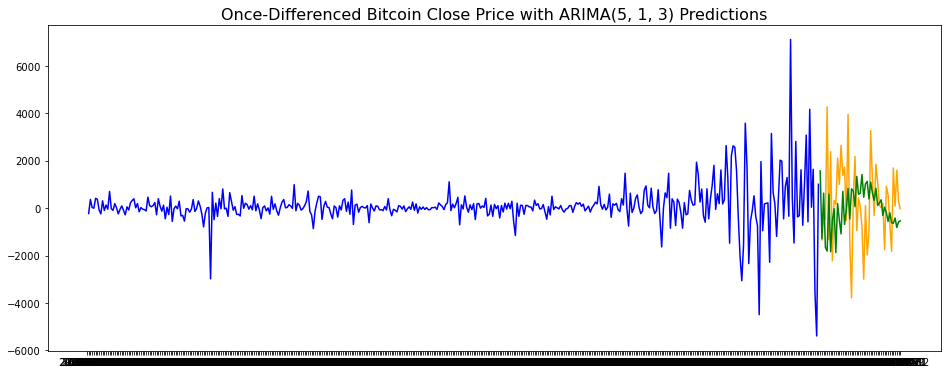

In [ ]:
model_arima = ARIMA(endog = y_train,
              order = (8,1,4))

arima = model_arima.fit()

preds = model_arima.predict(params=arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

plt.figure(figsize=(16,6))
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Once-Differenced Bitcoin Close Price with ARIMA(5, 1, 3) Predictions', fontsize=16)
plt.show();

In [ ]:
arima.summary()

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  420
Model:                 ARIMA(8, 1, 4)   Log Likelihood               -3414.111
Method:                       css-mle   S.D. of innovations            817.379
Date:                Sun, 25 Apr 2021   AIC                           6856.222
Time:                        12:04:01   BIC                           6912.785
Sample:                    01-02-2020   HQIC                          6878.578
                         - 02-24-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            93.1360     40.710      2.288      0.022      13.345     172.927
ar.L1.D.Close     0.5982      0.138      4.339      0.000       0.328       0.868
ar.L2.D.Close     0.7033      0.148      4.759      0.000       0.414       0.993
ar.L3.D.Close     0.2455      0.150      1.640      0.101      -0.048       0.539
ar.L4.D.Close    -0.6876      0.130     -5.279      0.000      -0.943      -0.432
ar.L5.D.Close     0.1334      0.077      1.743      0.081      -0.017       0.283
ar.L6.D.Close     0.1631      0.079      2.069      0.039       0.009       0.318
ar.L7.D.Close    -0.2507      0.088     -2.857      0.004      -0.423      -0.079
ar.L8.D.Close    -0.0157      0.081     -0.195      0.846      -0.174       0.143
ma.L1.D.Close    -0.5663      0.129     -4.384      0.000      -0.819      -0.313
ma.L2.D.Close    -0.8329      0.135     -6.159      0.000      -1.098      -0.568
ma.L3.D.Close    -0.2310      0.149     -1.554      0.120      -0.522       0.060
ma.L4.D.Close     0.7423      0.121      6.159      0.000       0.506       0.978
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9934           -0.1598j            1.0062           -0.0254
AR.2            0.9934           +0.1598j            1.0062            0.0254
AR.3           -0.7156           -0.7704j            1.0515           -0.3691
AR.4           -0.7156           +0.7704j            1.0515            0.3691
AR.5            0.7613           -1.3131j            1.5178           -0.1664
AR.6            0.7613           +1.3131j            1.5178            0.1664
AR.7           -1.4917           -0.0000j            1.4917           -0.5000
AR.8          -16.5513           -0.0000j           16.5513           -0.5000
MA.1           -0.8546           -0.7366j            1.1282           -0.3868
MA.2           -0.8546           +0.7366j            1.1282            0.3868
MA.3            1.0102           -0.1944j            1.0288           -0.0303
MA.4            1.0102           +0.1944j            1.0288            0.0303
-----------------------------------------------------------------------------
"""

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


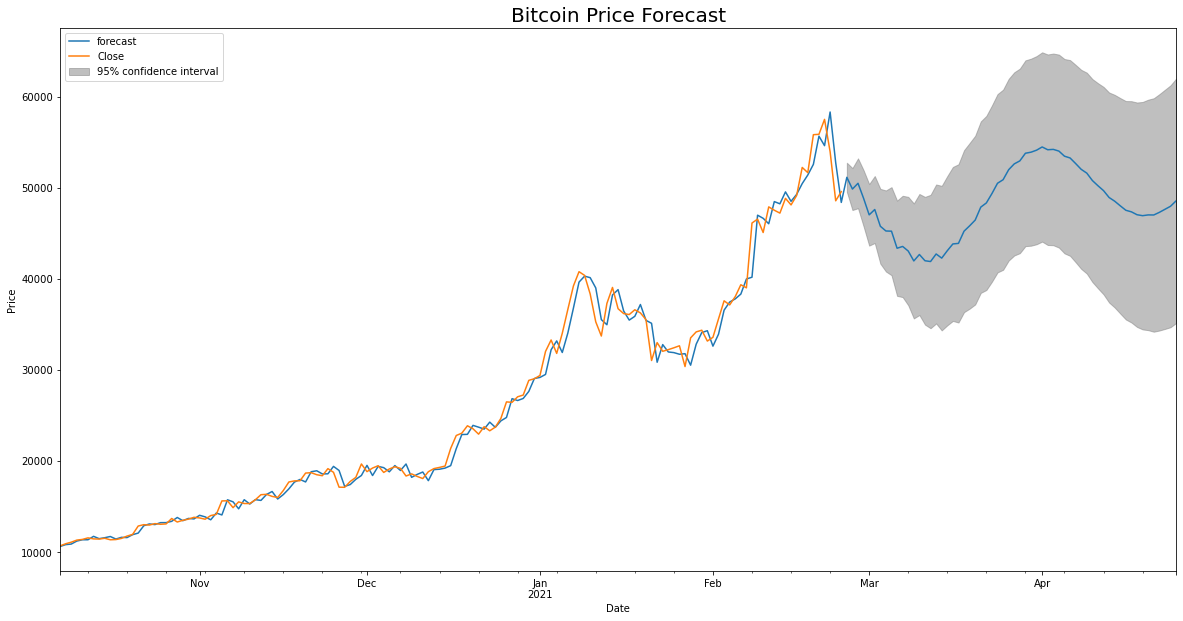

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
arima.plot_predict(
    start=280,
    end=480,
    dynamic=False,
    ax=ax,
)
plt.legend(loc=2)
plt.title('Bitcoin Price Forecast', size=20)
plt.ylabel('Price')
plt.xlabel('Date');

## Model 2: RandomForest

Before conducting our LSTM models, we need to have a baseline measurement for performance. We'll use RandomForestClassifier here as our baseline.

Here we conduct a train-test split and scale with StandardScaler. I had decided not to use MinMax scaling contrary to common practice in this field because cryptocurrencies is on a exponential growth curve as shown in earlier EDA sections, and does not make sense to cap to a range of 0 to 1 based on historical prices as we expect the ceiling to increase even further. Note that we also use `Target_shifted` as we want to predict the next day's buy/sell signal.

In [92]:
features = ['LogClose_Diff1',
            'LogAdrActCnt',
            'Target'
            ]

X = btc[features]
y = btc['Target_shifted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Gridsearch for best parameters

In [93]:
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

pipe_rf_parms = {
    'rf__n_estimators': [10,50,100,200,300,400],
    'rf__max_depth': [2,3,4,5],
    'rf__min_samples_split': [2,3,4,5,6]
}
rf_gs = GridSearchCV(
    pipe_rf,
    param_grid=pipe_rf_parms,
    cv=5
)

In [94]:
rf_gs.fit(X_train, y_train)
rf_gs.best_score_

0.5358346534333376

In [95]:
rf_gs.best_params_

{'rf__max_depth': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 10}

In [96]:
rf_gs_best = rf_gs.best_estimator_
rf_gs_best.score(X_test, y_test)

0.5856777493606138

In [97]:
y_test.value_counts(normalize=True)

1    0.585678
0    0.414322
Name: Target_shifted, dtype: float64

In [98]:
rf_gs_best.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

It seems that Random Forest does poorly by classifying every predictions as a buy, which explains why the accuracy score matches the proportion of buys in the dataset.

## Model 3: LSTM (LogClose_Diff1)

In [ ]:
btc.columns

Index(['Close', 'Close_Diff1', 'LogClose', 'LogClose_Diff1', 'Returns',
       'Target', 'Target_shifted', 'Year', 'HashRate', 'LogHashRate',
       'AdrActCnt', 'LogAdrActCnt', 'TxCnt', 'LogTxCnt', 'Goog_Trend',
       'Goog_Trend_Diff1'],
      dtype='object')

In [ ]:
features = ['LogClose_Diff1',
            'LogAdrActCnt',
            'Target'
            ]

In [ ]:
btc.dropna(inplace=True)

Train-test split and scale

In [ ]:
X = btc[features]
y = btc['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

TimeseriesGenerator

In [ ]:
lookback = 21
batchsize = 16

In [ ]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=lookback, batch_size=batchsize)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=lookback, batch_size=batchsize)

### Fit and predict

In [ ]:
model3 = Sequential()
model3.add(LSTM(50, input_shape=(lookback,X.shape[1]), return_sequences=True, activation='relu'))
model3.add(Dropout(0.5))
model3.add(LSTM(7, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 21, 50)            10800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7)                 1624      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 12,432
Trainable params: 12,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test.value_counts(normalize=True)

1    0.588235
0    0.411765
Name: Target, dtype: float64

Compile

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, mode='auto', restore_best_weights=True)

In [ ]:
history3 = model3.fit_generator(train_sequences, epochs=100, validation_data=test_sequences, shuffle=False, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
219/219 [==============================] - 6s 17ms/step - loss: 0.6935 - accuracy: 0.5184 - val_loss: 0.6843 - val_accuracy: 0.5919
Epoch 2/100
219/219 [==============================] - 3s 15ms/step - loss: 0.6905 - accuracy: 0.5182 - val_loss: 0.6843 - val_accuracy: 0.5919
Epoch 3/100
219/219 [==============================] - 3s 15ms/step - loss: 0.6891 - accuracy: 0.5374 - val_loss: 0.6836 - val_accuracy: 0.5919
Epoch 4/100
219/219 [==============================] - 3s 15ms/step - loss: 0.6852 - accuracy: 0.5498 - val_loss: 0.6835 - val_accuracy: 0.5919
Epoch 5/100
219/219 [==============================] - 3s 16ms/step - loss: 0.7590 - accuracy: 0.5555 - val_loss: 0.6840 - val_accuracy: 0.5946
Epoch 6/100
219/219 [==============================] - 3s 16ms/step - loss: 0.7015 - accuracy: 0.5417 - val_loss: 0.6826 - val_accuracy: 0.5919
Epoch 7/100
219/219 [==============================] - 3s 16ms/step - loss: 0.6842 - accuracy: 0.5496 - val_loss: 0.6834 - val_accuracy:

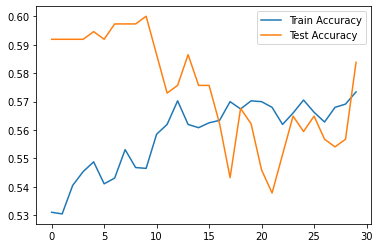

In [ ]:
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Test Accuracy')
plt.legend()

We observe 

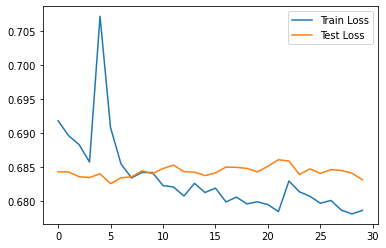

In [ ]:
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.legend()

In [ ]:
preds_test = model3.predict(test_sequences)

In [ ]:
test_preds = preds_test[:, 0]

In [ ]:
y_test.values[21:]

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
y_test.values[21:].shape

(370,)

In [ ]:
test_preds.shape

(370,)

In [ ]:
actual_y = np.array(y_test.values[21:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])

In [ ]:
preds['Match'].value_counts(normalize=True)

True     0.6
False    0.4
Name: Match, dtype: float64

In [ ]:
preds

,Y_Actual,Y_Pred,Match
0,0,0,True
1,0,0,True
2,0,1,False
3,1,1,True
4,0,1,False
...,...,...,...
365,1,1,True
366,0,1,False
367,1,1,True
368,1,1,True


In [ ]:
test_preds > 0.5

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
model.save("model_2016before.hdf5")

NameError: ignored

## Model 4: LSTM (LogClose)

This is the first LSTM model and it's run on the full dataset. Similar to earlier, we train-test split and scale our data with StandardScaler. Contrary to Model 2, we use `Target` instead of `Target_shifted` as TimeseriesGenerator will take the next day's buy/sell signal by nature of design.

In [ ]:
btc.columns

Index(['Close', 'Close_Diff1', 'LogClose', 'LogClose_Diff1', 'Returns',
       'Target', 'Target_shifted', 'Year', 'HashRate', 'LogHashRate',
       'AdrActCnt', 'LogAdrActCnt', 'TxCnt', 'LogTxCnt', 'Goog_Trend',
       'Goog_Trend_Diff1'],
      dtype='object')

In [ ]:
features = ['LogClose',
            'Target',
            'LogAdrActCnt',
            ]

In [ ]:
X = btc[features]
y = btc['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Take a look at the shapes of train and test sets

In [ ]:
X_train_sc.shape

(3516, 3)

In [ ]:
X_test_sc.shape

(391, 3)

We use Keras' TimeseriesGenerator to simplify the pre-processing of our time-series data that we feed into the LSTM model.

In [ ]:
lookback = 21
batchsize = 16

In [ ]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=lookback, batch_size=batchsize)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=lookback, batch_size=batchsize)

### Fit and predict

We instantiate Sequential() and add layers for our architechture. My model consists of 2 LSTM layers and 1 output Dense layer with a single layer of dropout between the LSTM layers.

In [ ]:
model3 = Sequential()
model3.add(LSTM(50, input_shape=(lookback,X.shape[1]), return_sequences=True, activation='relu'))
model3.add(Dropout(0.5))
model3.add(LSTM(7, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 21, 50)            10800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 7)                 1624      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
Total params: 12,432
Trainable params: 12,432
Non-trainable params: 0
_________________________________________________________________


Compile model with binary crossentropy loss, Adam optimizer and accuracy as our target metric.

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We also create an early_stop to prevent our model for running unnecessarily long.

Fit model

In [ ]:
history = model3.fit_generator(train_sequences, epochs=500, validation_data=test_sequences, shuffle=False, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6829 - accuracy: 0.5462 - val_loss: 0.6895 - val_accuracy: 0.5297
Epoch 2/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6827 - accuracy: 0.5445 - val_loss: 0.6853 - val_accuracy: 0.5432
Epoch 3/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6830 - accuracy: 0.5448 - val_loss: 0.6885 - val_accuracy: 0.5351
Epoch 4/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6825 - accuracy: 0.5508 - val_loss: 0.6866 - val_accuracy: 0.5432
Epoch 5/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6829 - accuracy: 0.5485 - val_loss: 0.6867 - val_accuracy: 0.5703
Epoch 6/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6818 - accuracy: 0.5465 - val_loss: 0.6843 - val_accuracy: 0.5568
Epoch 7/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6815 - accuracy: 0.5502 - val_loss: 0.6883 - val_accuracy:

Plot the accuracy and loss curves

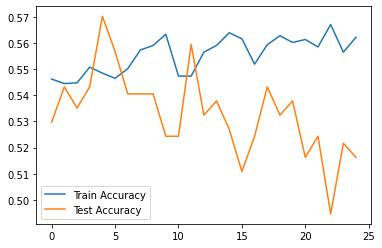

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()

It's interesting to note that as the model learns about the train dataset through the increasing epochs, train accuracy clearly increases but does not transfer the learning to the test set.

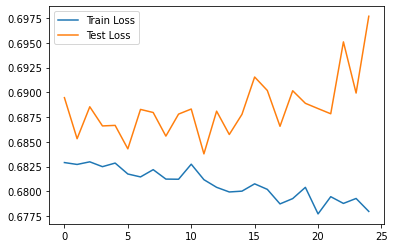

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [ ]:
preds_test = model4.predict(test_sequences)
test_preds = preds_test[:, 0]
y_test.values[14:]

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,

Take a look at their shapes to make sure they are the same

In [ ]:
y_test.values[21:].shape

(370,)

In [ ]:
test_preds.shape

(370,)

In [ ]:
actual_y = np.array(y_test.values[21:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])
preds.head()

,Y_Actual,Y_Pred,Match
0,0,1,False
1,0,1,False
2,0,1,False
3,1,1,True
4,0,1,False


In [ ]:
test_preds > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
actual_y = np.array(y_test.values[21:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])
preds.head()

,Y_Actual,Y_Pred,Match
0,0,1,False
1,0,1,False
2,0,1,False
3,1,1,True
4,0,1,False


In [ ]:
test_preds > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Model 5: LSTM (LogClose_Diff1 + Google Trends)

This is the first LSTM model and it's run on the full dataset. Similar to earlier, we train-test split and scale our data with StandardScaler. Contrary to Model 2, we use `Target` instead of `Target_shifted` as TimeseriesGenerator will take the next day's buy/sell signal by nature of design.

In [ ]:
btc.columns

Index(['Close', 'Close_Diff1', 'LogClose', 'LogClose_Diff1', 'Returns',
       'Target', 'Target_shifted', 'Year', 'HashRate', 'LogHashRate',
       'AdrActCnt', 'LogAdrActCnt', 'TxCnt', 'LogTxCnt', 'Goog_Trend',
       'Goog_Trend_Diff1'],
      dtype='object')

In [ ]:
features = ['LogClose',
            'Goog_Trend',
            'Target',
            'LogAdrActCnt',
            ]

In [ ]:
X = btc[features]
y = btc['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Take a look at the shapes of train and test sets

In [ ]:
X_train_sc.shape

(3516, 4)

In [ ]:
X_test_sc.shape

(391, 4)

We use Keras' TimeseriesGenerator to simplify the pre-processing of our time-series data that we feed into the LSTM model.

In [ ]:
lookback = 21
batchsize = 16

In [ ]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=lookback, batch_size=batchsize)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=lookback, batch_size=batchsize)

### Fit and predict

We instantiate Sequential() and add layers for our architechture. My model consists of 2 LSTM layers and 1 output Dense layer with a single layer of dropout between the LSTM layers.

In [ ]:
model5 = Sequential()
model5.add(LSTM(50, input_shape=(lookback,X.shape[1]), return_sequences=True, activation='relu'))
model5.add(Dropout(0.5))
model5.add(LSTM(7, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 21, 50)            11000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 7)                 1624      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 8         
Total params: 12,632
Trainable params: 12,632
Non-trainable params: 0
_________________________________________________________________


Compile model with binary crossentropy loss, Adam optimizer and accuracy as our target metric.

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We also create an early_stop to prevent our model for running unnecessarily long.

Fit model

In [ ]:
history = model5.fit_generator(train_sequences, epochs=500, validation_data=test_sequences, shuffle=False, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
219/219 [==============================] - 6s 17ms/step - loss: 0.6954 - accuracy: 0.5135 - val_loss: 0.6886 - val_accuracy: 0.5919
Epoch 2/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6897 - accuracy: 0.5335 - val_loss: 0.6881 - val_accuracy: 0.5919
Epoch 3/500
219/219 [==============================] - 3s 15ms/step - loss: 0.7122 - accuracy: 0.5257 - val_loss: 0.6841 - val_accuracy: 0.5919
Epoch 4/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6935 - accuracy: 0.5279 - val_loss: 0.6869 - val_accuracy: 0.5919
Epoch 5/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6885 - accuracy: 0.5261 - val_loss: 0.6896 - val_accuracy: 0.5649
Epoch 6/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6873 - accuracy: 0.5231 - val_loss: 0.6872 - val_accuracy: 0.5784
Epoch 7/500
219/219 [==============================] - 3s 15ms/step - loss: 0.6864 - accuracy: 0.5275 - val_loss: 0.6885 - val_accuracy:

Plot the accuracy and loss curves

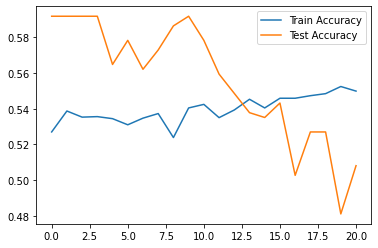

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()

It's interesting to note that as the model learns about the train dataset through the increasing epochs, train accuracy clearly increases but does not transfer the learning to the test set.

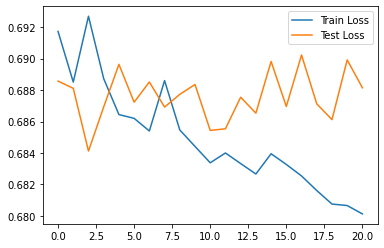

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [ ]:
preds_test = model5.predict(test_sequences)
test_preds = preds_test[:, 0]
y_test.values[21:]

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

Take a look at their shapes to make sure they are the same

In [ ]:
y_test.values[21:].shape

(370,)

In [ ]:
test_preds.shape

(370,)

In [ ]:
actual_y = np.array(y_test.values[21:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])
preds.head()

,Y_Actual,Y_Pred,Match
0,0,1,False
1,0,1,False
2,0,1,False
3,1,1,True
4,0,1,False


In [ ]:
test_preds > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
actual_y = np.array(y_test.values[21:])
pred_y = np.array(test_preds)

preds = pd.DataFrame(actual_y, columns=['Y_Actual'])
preds['Y_Predicted'] = pred_y
preds['Y_Pred'] = np.where(preds['Y_Predicted'] > 0.5, 1, 0)
preds.drop(columns=['Y_Predicted'], inplace=True)

preds['Match'] = (preds['Y_Actual'] == preds['Y_Pred'])
preds.head()

,Y_Actual,Y_Pred,Match
0,0,1,False
1,0,1,False
2,0,1,False
3,1,1,True
4,0,1,False


In [ ]:
test_preds > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## Model 6: LSTM Price Prediction (Lookback = 1)

In [59]:
features = [
    'LogClose',
]

btc = btc[features]

In [60]:
scaler = StandardScaler()
btc_scaled = scaler.fit_transform(btc)

X = btc_scaled
y = btc_scaled[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)

TimeseriesGenerator

In [61]:
lookback = 1
batchsize = 32

In [62]:
train_sequences = TimeseriesGenerator(X_train, y_train, length=lookback, batch_size=batchsize, sampling_rate=1)
test_sequences = TimeseriesGenerator(X_test, y_test, length=lookback, batch_size=batchsize, sampling_rate=1)

### Fit and predict

In [63]:
model = Sequential()
model.add(LSTM(60, input_shape=(lookback,X_train.shape[1]), return_sequences=True, activation='relu'))
model.add(LSTM(60))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 60)             14880     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 45,471
Trainable params: 45,471
Non-trainable params: 0
_________________________________________________________________


In [65]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'auto')
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [66]:
history = model.fit_generator(
    train_sequences, 
    epochs=50, 
    validation_data=test_sequences, 
    shuffle=False,
    callbacks=[early_stop]
)

Epoch 1/50
98/98 [==============================] - 4s 43ms/step - loss: 0.1134 - mean_absolute_error: 0.1137 - val_loss: 0.0923 - val_mean_absolute_error: 0.0904
Epoch 2/50
98/98 [==============================] - 1s 8ms/step - loss: 0.1084 - mean_absolute_error: 0.1087 - val_loss: 0.0827 - val_mean_absolute_error: 0.0808
Epoch 3/50
98/98 [==============================] - 1s 8ms/step - loss: 0.1049 - mean_absolute_error: 0.1052 - val_loss: 0.0819 - val_mean_absolute_error: 0.0801
Epoch 4/50
98/98 [==============================] - 1s 9ms/step - loss: 0.1036 - mean_absolute_error: 0.1039 - val_loss: 0.0767 - val_mean_absolute_error: 0.0749
Epoch 5/50
98/98 [==============================] - 1s 8ms/step - loss: 0.1008 - mean_absolute_error: 0.1011 - val_loss: 0.0747 - val_mean_absolute_error: 0.0730
Epoch 6/50
98/98 [==============================] - 1s 8ms/step - loss: 0.0981 - mean_absolute_error: 0.0984 - val_loss: 0.0750 - val_mean_absolute_error: 0.0734
Epoch 7/50
98/98 [=========

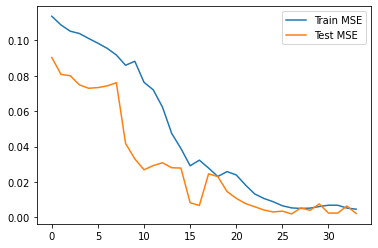

In [67]:
plt.plot(history.history['mean_absolute_error'], label='Train MSE')
plt.plot(history.history['val_mean_absolute_error'], label='Test MSE')
plt.legend()

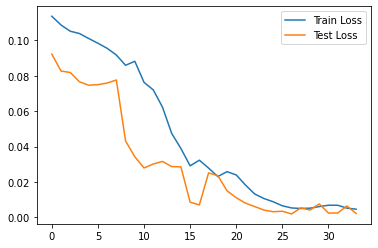

In [68]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [69]:
model.evaluate_generator(test_sequences)

[0.0021752764377743006, 0.0021459567]

In [70]:
predictions=model.predict_generator(test_sequences)

In [71]:
X_test[:,1:][lookback:]

array([], shape=(781, 0), dtype=float64)

In [72]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][lookback:])],axis=1)
df_pred = scaler.inverse_transform(df_pred)
df_pred_final = btc[predictions.shape[0]*-1:]
df_pred_final['Pred'] = df_pred[:,0]
df_pred_final['Pred_Diff'] = df_pred_final['LogClose'] - df_pred_final['Pred']

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [73]:
df_pred_final

,LogClose,Pred,Pred_Diff
Date,,,
2019-02-10,8.200294,8.225202,-0.024907
2019-02-11,8.186080,8.230721,-0.044641
2019-02-12,8.185323,8.216991,-0.031668
2019-02-13,8.182024,8.216261,-0.034237
2019-02-14,8.178054,8.213075,-0.035021
...,...,...,...
2021-03-27,10.933461,10.867527,0.065934
2021-03-28,10.927969,10.888735,0.039235
2021-03-29,10.960778,10.883367,0.077412


Text(0.5, 1.0, 'LSTM Price Prediction (1 Day Lookback)')

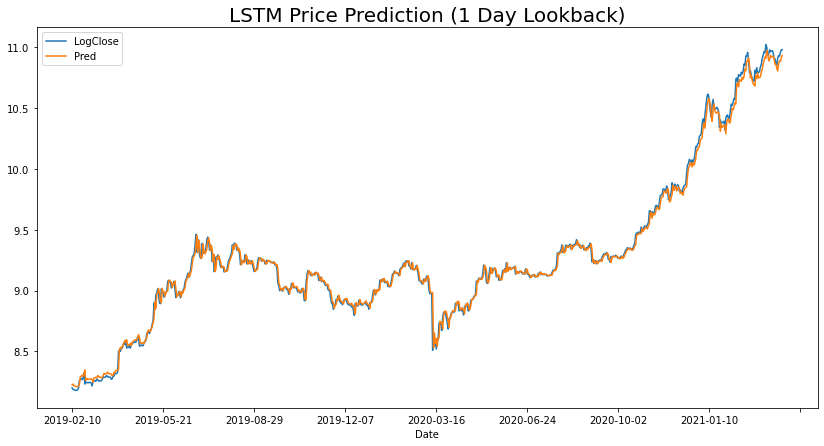

In [74]:
df_pred_final[['LogClose','Pred']].plot(figsize=(14,7))
plt.title('LSTM Price Prediction (1 Day Lookback)', size=20)

## Model 7: LSTM Price Prediction (Lookback = 7)

In [31]:
lookback = 7
batchsize = 32

In [32]:
train_sequences = TimeseriesGenerator(X_train, y_train, length=lookback, batch_size=batchsize, sampling_rate=1)
test_sequences = TimeseriesGenerator(X_test, y_test, length=lookback, batch_size=batchsize, sampling_rate=1)

### Fit and predict

In [33]:
model = Sequential()
model.add(LSTM(60, input_shape=(lookback,X_train.shape[1]), return_sequences=True, activation='relu'))
model.add(LSTM(60))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 60)             14880     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 45,471
Trainable params: 45,471
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

In [46]:
history = model.fit_generator(
    train_sequences, 
    epochs=50, 
    validation_data=test_sequences, 
    shuffle=False,
    callbacks=[early_stop]
)

Epoch 1/50
98/98 [==============================] - 6s 61ms/step - loss: 0.0308 - mean_absolute_error: 0.0309 - val_loss: 0.0349 - val_mean_absolute_error: 0.0335
Epoch 2/50
98/98 [==============================] - 3s 28ms/step - loss: 0.0307 - mean_absolute_error: 0.0309 - val_loss: 0.0407 - val_mean_absolute_error: 0.0395
Epoch 3/50
98/98 [==============================] - 3s 29ms/step - loss: 0.0229 - mean_absolute_error: 0.0230 - val_loss: 0.0408 - val_mean_absolute_error: 0.0397
Epoch 4/50
98/98 [==============================] - 2s 25ms/step - loss: 0.0207 - mean_absolute_error: 0.0208 - val_loss: 0.0255 - val_mean_absolute_error: 0.0246
Epoch 5/50
98/98 [==============================] - 3s 26ms/step - loss: 0.0148 - mean_absolute_error: 0.0149 - val_loss: 0.0155 - val_mean_absolute_error: 0.0150
Epoch 6/50
98/98 [==============================] - 3s 26ms/step - loss: 0.0132 - mean_absolute_error: 0.0132 - val_loss: 0.0392 - val_mean_absolute_error: 0.0382
Epoch 7/50
98/98 [====

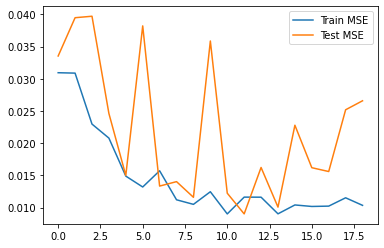

In [47]:
plt.plot(history.history['mean_absolute_error'], label='Train MSE')
plt.plot(history.history['val_mean_absolute_error'], label='Test MSE')
plt.legend()

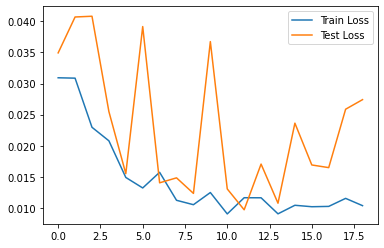

In [48]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [49]:
model.evaluate_generator(test_sequences)

[0.027413691505789758, 0.026579203]

In [50]:
predictions=model.predict_generator(test_sequences)

In [51]:
X_test[:,1:][lookback:]

array([], shape=(775, 0), dtype=float64)

In [52]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][lookback:])],axis=1)
df_pred = scaler.inverse_transform(df_pred)
df_pred_final = btc[predictions.shape[0]*-1:]
df_pred_final['Pred'] = df_pred[:,0]
df_pred_final['Pred_Diff'] = df_pred_final['LogClose'] - df_pred_final['Pred']

C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\tensorflowdsi\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [53]:
df_pred_final

,LogClose,Pred,Pred_Diff
Date,,,
2019-02-16,8.184440,8.046358,0.138082
2019-02-17,8.194991,8.044693,0.150298
2019-02-18,8.260009,8.043491,0.216518
2019-02-19,8.267561,8.049264,0.218297
2019-02-20,8.276805,8.058278,0.218527
...,...,...,...
2021-03-27,10.933461,10.186732,0.746729
2021-03-28,10.927969,10.180206,0.747763
2021-03-29,10.960778,10.176823,0.783956


Text(0.5, 1.0, 'LSTM Price Prediction (7 Days Lookback)')

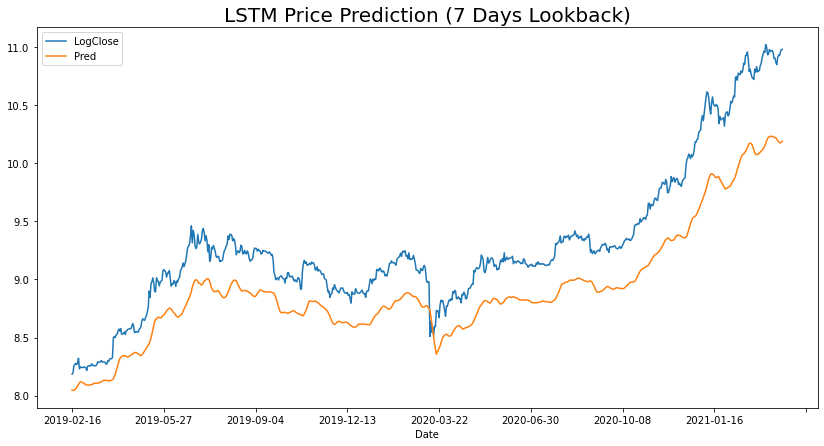

In [57]:
df_pred_final[['LogClose','Pred']].plot(figsize=(14,7))
plt.title('LSTM Price Prediction (7 Days Lookback)', size=20)

# Analysis

## Best Model

## Misclassifications

# Conclusion